In [22]:
# 将MNIST样本集转化为TFRecord格式

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


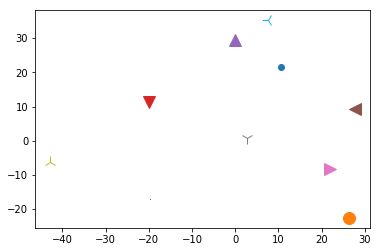

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.manifold import TSNE


class KMeans(object):
    """
    - 参数
        n_clusters:
            聚类个数，即k
        initCent:
            质心初始化方式，可选"random"或指定一个具体的array,默认random，即随机初始化
        max_iter:
            最大迭代次数
    """

    def __init__(self, n_clusters=10, initCent='random', max_iter=300):
        if hasattr(initCent, '__array__'):
            n_clusters = initCent.shape[0]
            self.centroids = np.asarray(initCent, dtype=np.float)
        else:
            self.centroids = None

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.initCent = initCent
        self.clusterAssment = None
        self.labels = None
        self.sse = None

    # 计算两点的欧式距离
    def _distEclud(self, vecA, vecB):
        return np.linalg.norm(vecA - vecB)

    def fit(self, X):
        m = X.shape[0]  # m代表样本数量
        self.clusterAssment = np.empty((m, 2))     # m*2的矩阵，第一列存储样本点所属的族的索引值，
                                                    # 第二列存储该点与所属族的质心的平方误差

        clusterChanged = True
        for _ in range(self.max_iter):
            clusterChanged = False
            for i in range(m):  # 将每个样本点分配到离它最近的质心所属的族
                minDist = np.inf
                minIndex = -1
                for j in range(self.n_clusters):
                    distJI = self._distEclud(self.centroids[j,:],X[i,:])
                    if distJI < minDist:
                        minDist = distJI
                        minIndex = j
                if self.clusterAssment[i, 0] != minIndex:
                    clusterChanged = True
                    self.clusterAssment[i, :] = minIndex, minDist**2

            if not clusterChanged:  # 若所有样本点所属的族都不改变,则已收敛，结束迭代
                break
            for i in range(self.n_clusters):  # 更新质心，即将每个族中的点的均值作为质心
                ptsInClust = X[np.nonzero(self.clusterAssment[:, 0] == i)[0]]  
                # 取出属于第i个族的所有点
                self.centroids[i, :] = np.mean(ptsInClust, axis=0)

        self.labels = self.clusterAssment[:, 0]
        self.sse = sum(self.clusterAssment[:, 1])

    def predict(self, X):  # 根据聚类结果，预测新输入数据所属的族
        m = X.shape[0]  # m代表样本数量
        preds = np.empty((m,))
        for i in range(m):  # 将每个样本点分配到离它最近的质心所属的族
            minDist = np.inf
            for j in range(self.n_clusters):
                distJI = self._distEclud(self.centroids[j, :], X[i, :])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds


if __name__ == "__main__":
    n_clusters = 10
    train_num = 1000
    mnist = input_data.read_data_sets('data/fashion', one_hot=True)
    X, y = mnist.train.next_batch(50)
    train_images = mnist.train.images
    X = TSNE().fit_transform(train_images[:train_num])    
    clf = KMeans(n_clusters=n_clusters, initCent=X[0:10], max_iter=100)    
    clf.fit(X)
    cents = clf.centroids  # 质心
    labels = clf.labels  # 样本点被分配到的簇的索引
    sse = clf.sse
    markers = ['.', 'o', ',', 'v', '^', '<', '>', '1', '2', '3']
    for i in range(0, n_clusters):
        plt.plot(cents[i, 0], cents[i, 1], markers[i], markersize=12)
    plt.show()